In [1]:
from src.HestonModel import generate_heston_paths
import numpy as np
import esig
import matplotlib.pyplot as plt
import iisignature
import signatory
import torch
from tqdm.auto import tqdm

In [2]:
# constant Heston parameters
kappa = 3
theta = 0.02
v_0 = theta #
rho = 0.75
sigma = 0.6
r = 0.04

S = 100
paths = 10000
steps = 50
T = 1

In [3]:
# Get Heston prices and volatilises
prices, sigs = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, sigma, steps, paths, return_vol=True)

In [4]:
prices.shape

(10000, 50)

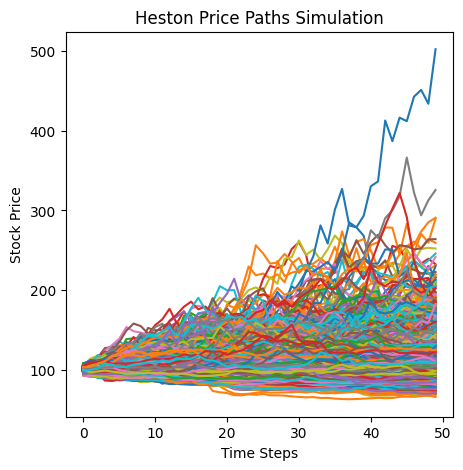

In [5]:
# Plot Heston Price paths
plt.figure(figsize=(5, 5))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()


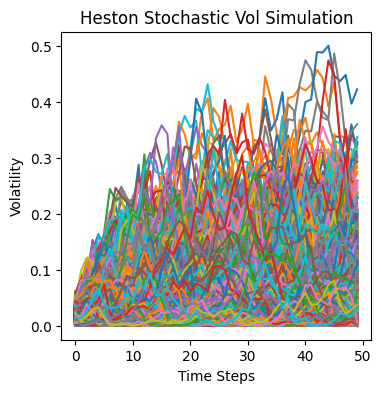

In [6]:
# Plot Heston volatility paths
plt.figure(figsize=(4, 4))
plt.plot(sigs.T)
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.show()

In [7]:
#############################################################################################

In [8]:
thetas=0.15 #Long run variance θ
kappas= 2 # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = np.arange(0.0,1.1,0.002) #Volatility of variance σ
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [9]:
a=np.random.uniform(.5,5,500)
b=np.arange(.5,5.0,0.01)

In [10]:
depth_of_sig=2  #level of truncation of signatures
width_of_sig=3  # prices + sigmas + time_array (parameters for signatures)
sig_keys = esig.sigkeys(width_of_sig, depth_of_sig)
sig_dim=signatory.signature_channels(width_of_sig,depth_of_sig)

In [11]:
# define time_array and empty tensor for prices and sigmas, signatures and expected signatures
time_array = np.arange(steps)
prices_and_sigs_with_time_tensor = torch.zeros((paths,steps, width_of_sig ))
number_of_loops=sigmas.shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape
number_of_loops
prices_and_sigs_with_time_tensor.shape

torch.Size([10000, 100, 3])

In [12]:
def signatures_calculations_sigmas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for sigma in sigmas:
            # Caclulation of 10000 paths of prices and sigmas
            prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths, return_vol=True)

            for j in range(paths):
                     prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                    #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

            sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
            #     shape of  sign_ps_signatory_differentranges=torch.Size([512, 10000, 12])

            Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
            #     shape of  Exp_sign_signatory_results=torch.Size([512, 12])

            count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [13]:
results_sigmas=signatures_calculations_sigmas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_sigmas=results_sigmas[0]
Exp_signatures_results_sigmas=results_sigmas[1]

In [14]:
Exp_signatures_results_sigmas.shape

torch.Size([550, 12])

In [15]:
signatures_results_sigmas.shape

torch.Size([550, 10000, 12])

In [16]:
signatures_results_sigmas[0].shape

torch.Size([10000, 12])

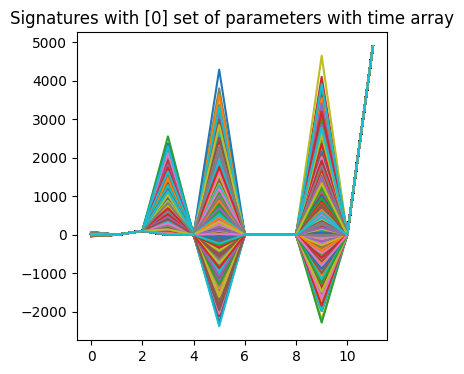

In [17]:
plt.figure(figsize=(4, 4))
plt.plot(signatures_results_sigmas[0].T)  #there are 512 sets of parameters
plt.title("Signatures with [0] set of parameters with time array")
plt.show()

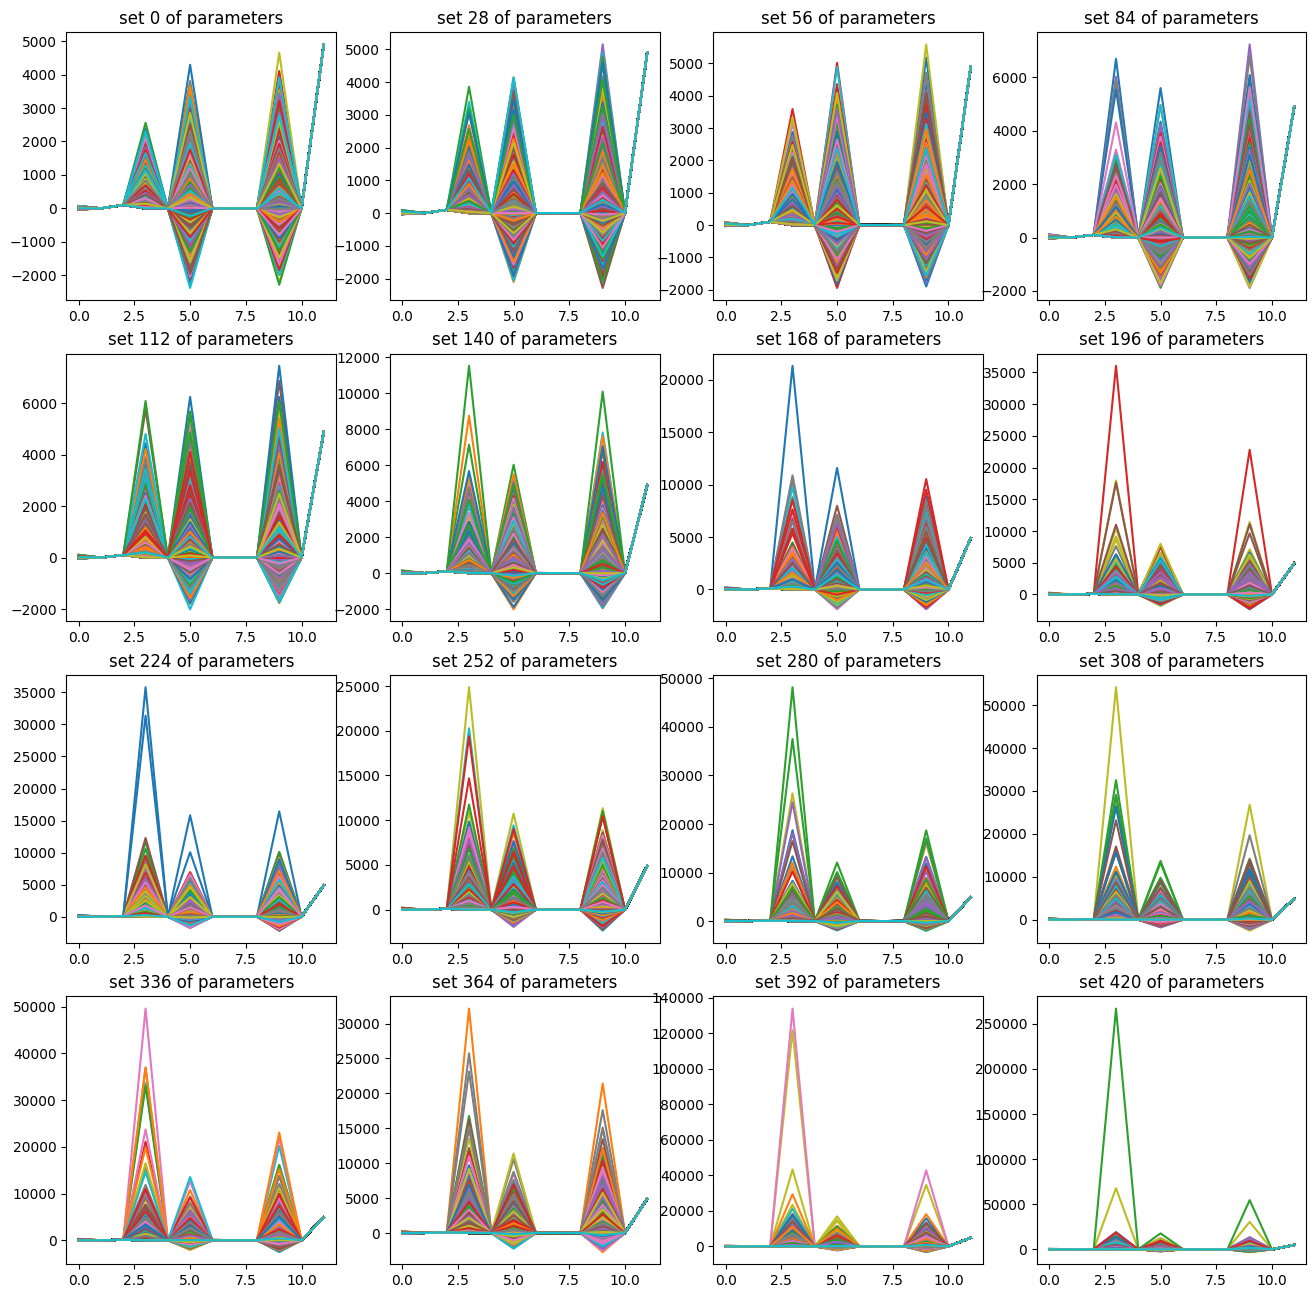

In [18]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text("set " + str(i*28)+" of parameters")
    ax.plot(signatures_results_sigmas[i*28].T)
#     Plot 10000 signatures for each set of parameters
#     There are big changes on each plot, which are formed on the signature keys (1,1), (1,3), (3,1)

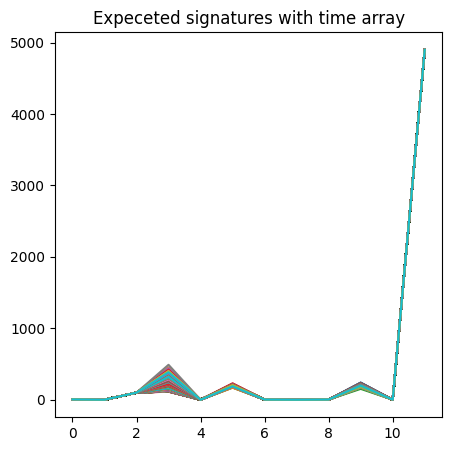

In [19]:
plt.figure(figsize=(5, 5))
plt.plot(Exp_signatures_results_sigmas.T[:])
plt.title("Expeceted signatures with time array")
plt.show()
# Plot 512 expected signatures

In [20]:
Exp_signatures_results_sigmas.T.shape

torch.Size([12, 550])

In [34]:
# list(range(len(kappas)))

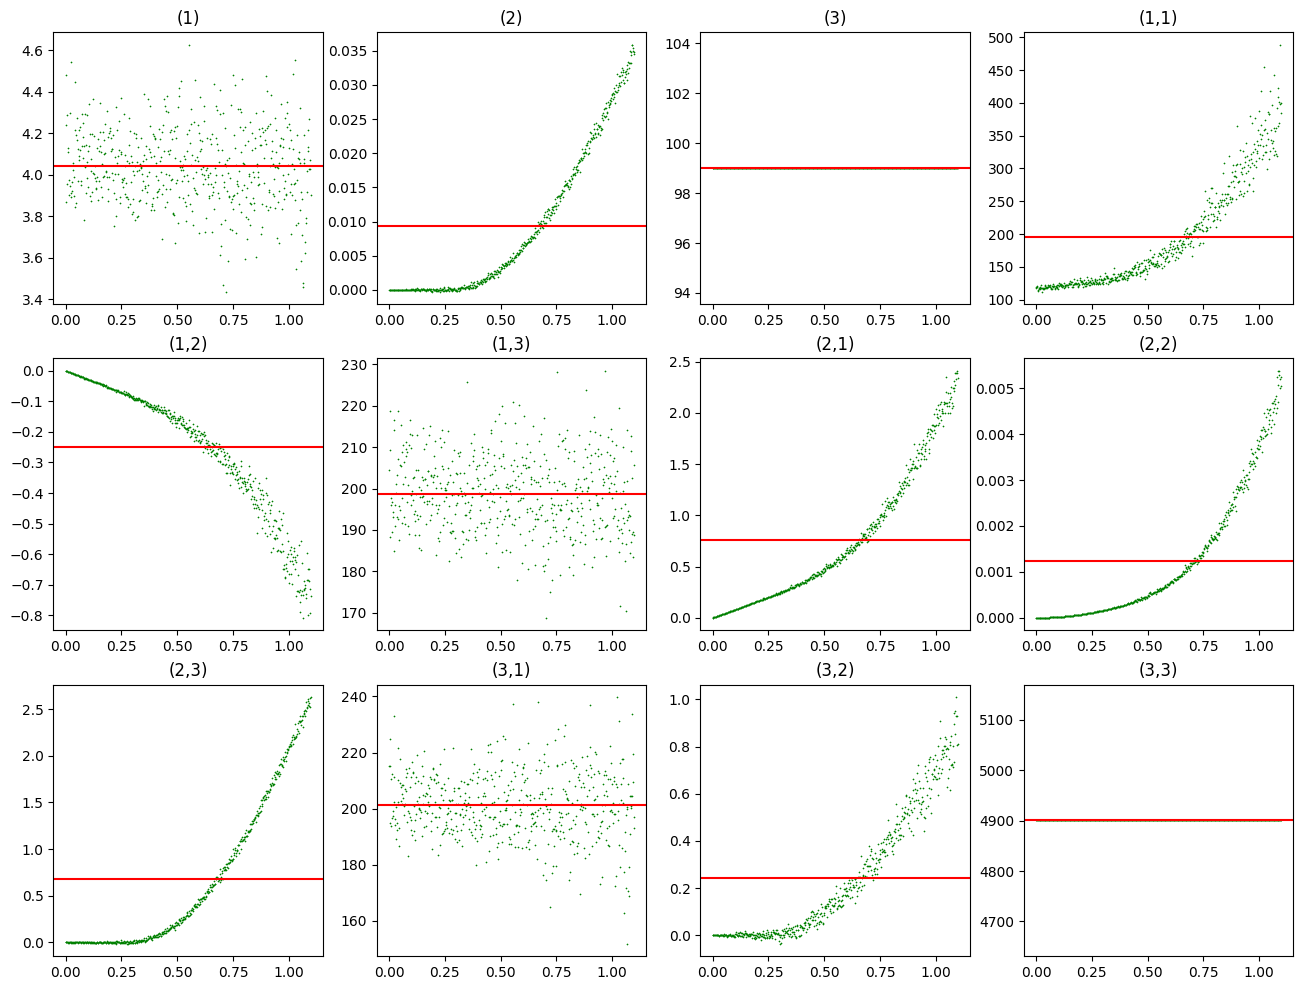

In [36]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(sigmas,Exp_signatures_results_sigmas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_sigmas.T[i]), color='red')

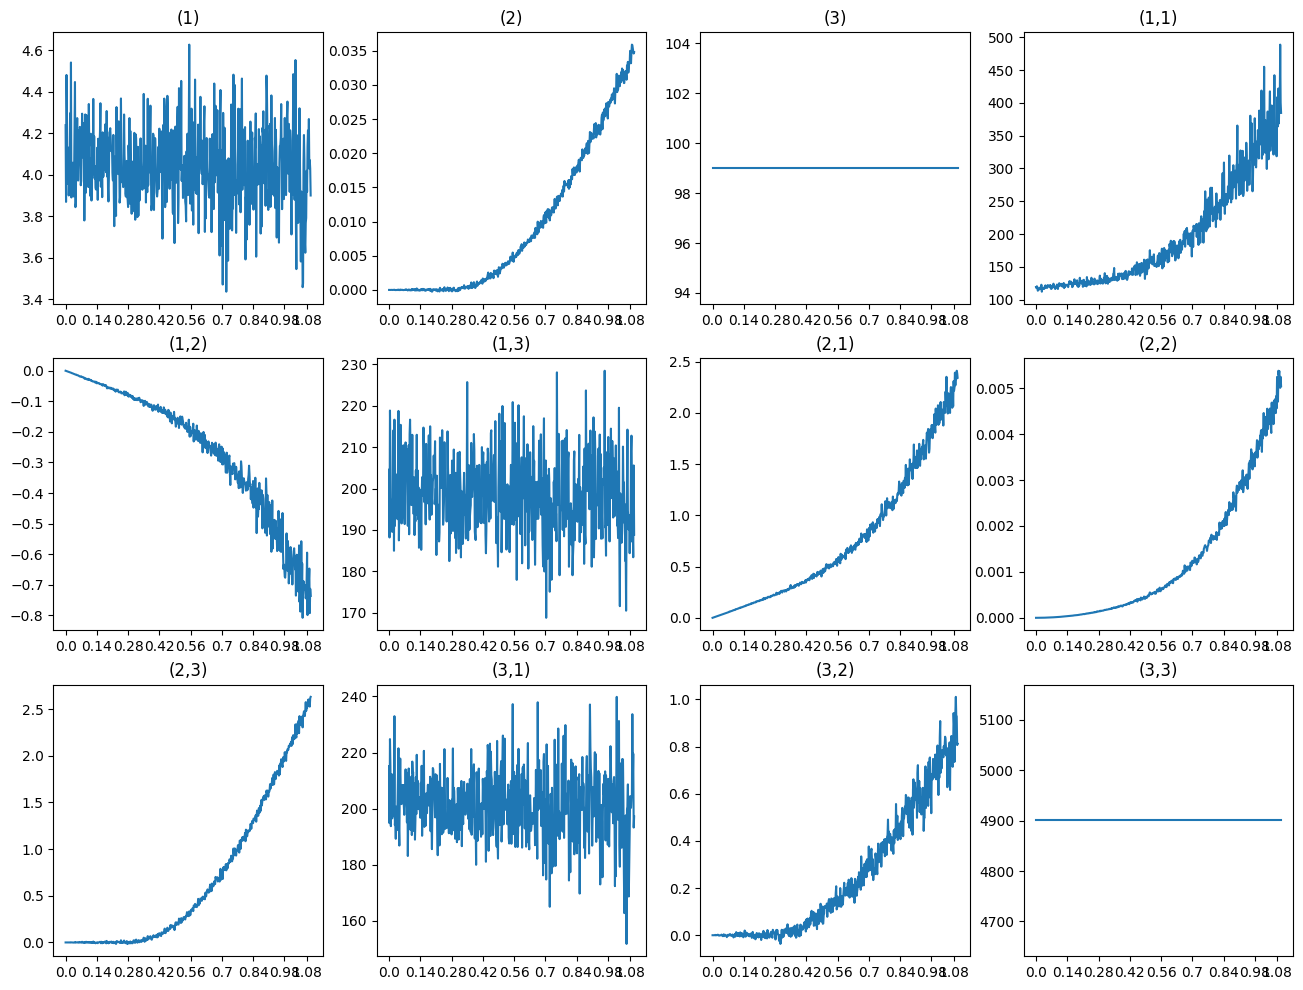

In [33]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_sigmas.T[i])
    ax.set_xticks([0,70,140, 210,280,350,420,490,540],[round(x,3) for x in list(sigmas[[0,70,140, 210,280,350,420,490,540]])])
    # ax.set_xticks(ticks=list(range(len(kappas))),labels=kappas)

#     For each key of the signature, plot the evolving Expected Signature depending on the sigmas's values
#     We can note, that most of the keys of the expected signature depend on sigmas's value. Namely, the bigger sigma we have the higher value of the       key, especially for keys that depend on Sigma ( (2), (1,1), (2,1), (2,2), (2,3) and (3,2)). However, the key (1,2) has the complete opposite          trend, i.e. as the value of Sigma increases, so does the value of Key (1,2). Moreover, the keys (1,1), (1,2) and (3,2) of expected signature          have greater volatility at higher Sigma values.
#     For time keys like (3) and (3,3) we have constant, since it does not change from the parameters
#     However, for the keys (1), (1,3) and (3,1) we cannot say anything in particular, they have a big volatility.

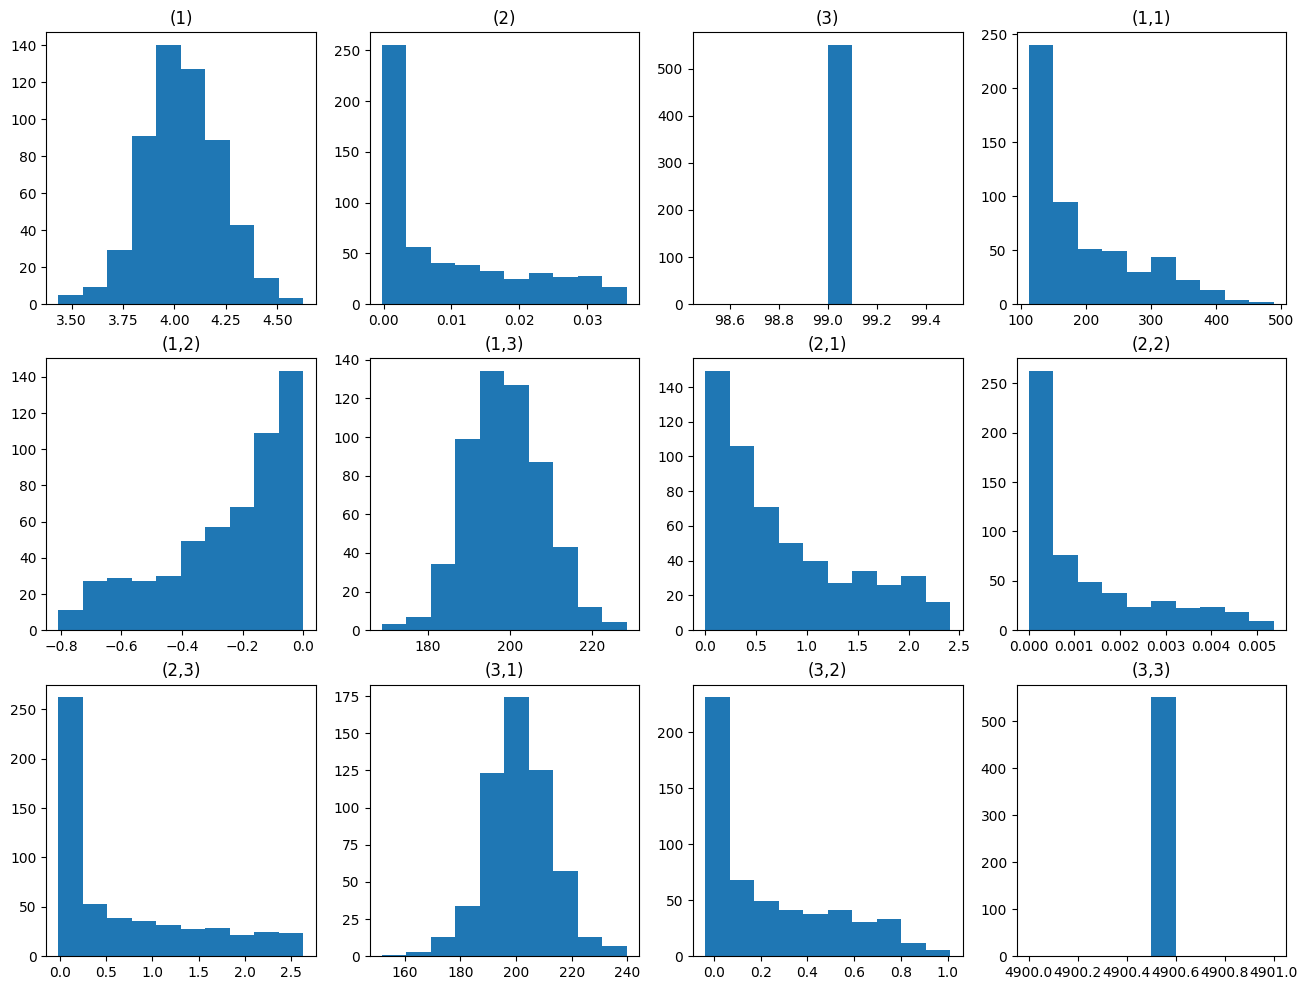

In [23]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.hist(Exp_signatures_results_sigmas.T[i])

# Although, if you change the order of parameters in the function "signatures_calculations_with_timearray",
# the graphs of each Expected signature key are different, their histograms are similar.

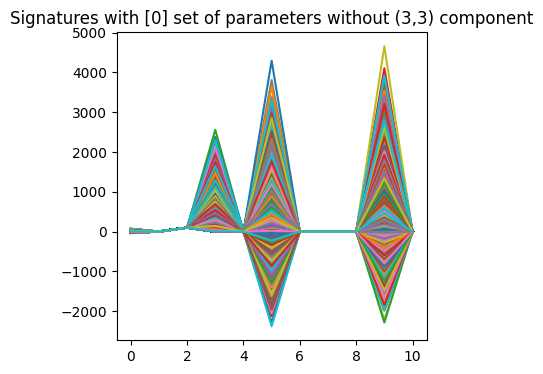

In [24]:
plt.figure(figsize=(4, 4))
plt.plot(signatures_results_sigmas[0].T[:-1])  #there are 512 sets of parameters #excluded the last component to better understand the graph, since its value is too big
plt.title("Signatures with [0] set of parameters without (3,3) component")
plt.show()

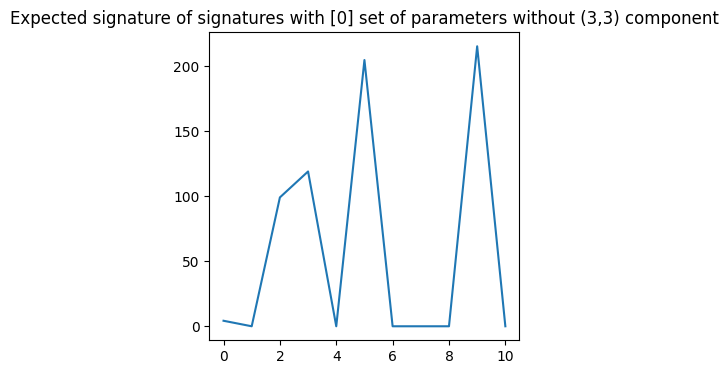

In [25]:
plt.figure(figsize=(4, 4))
plt.plot(Exp_signatures_results_sigmas[0].T[:-1])  #there are 512 sets of parameters #exclude last component, since its value is too big
plt.title("Expected signature of signatures with [0] set of parameters without (3,3) component")
plt.show()

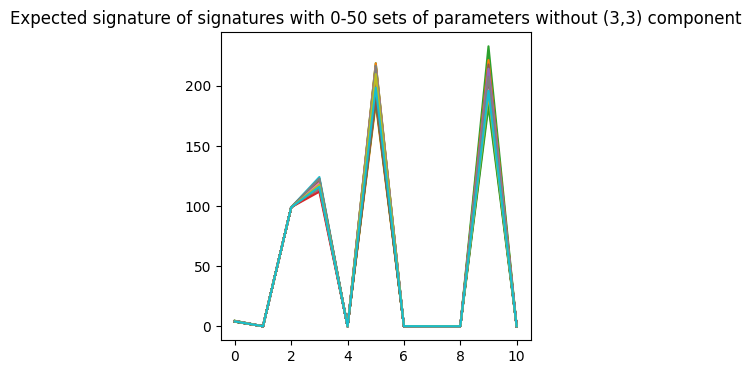

In [26]:
plt.figure(figsize=(4, 4))
plt.plot(Exp_signatures_results_sigmas[:50].T[:-1])  #there are 512 sets of parameters #exclude last component, since its value is too big
plt.title("Expected signature of signatures with 0-50 sets of parameters without (3,3) component")
plt.show()

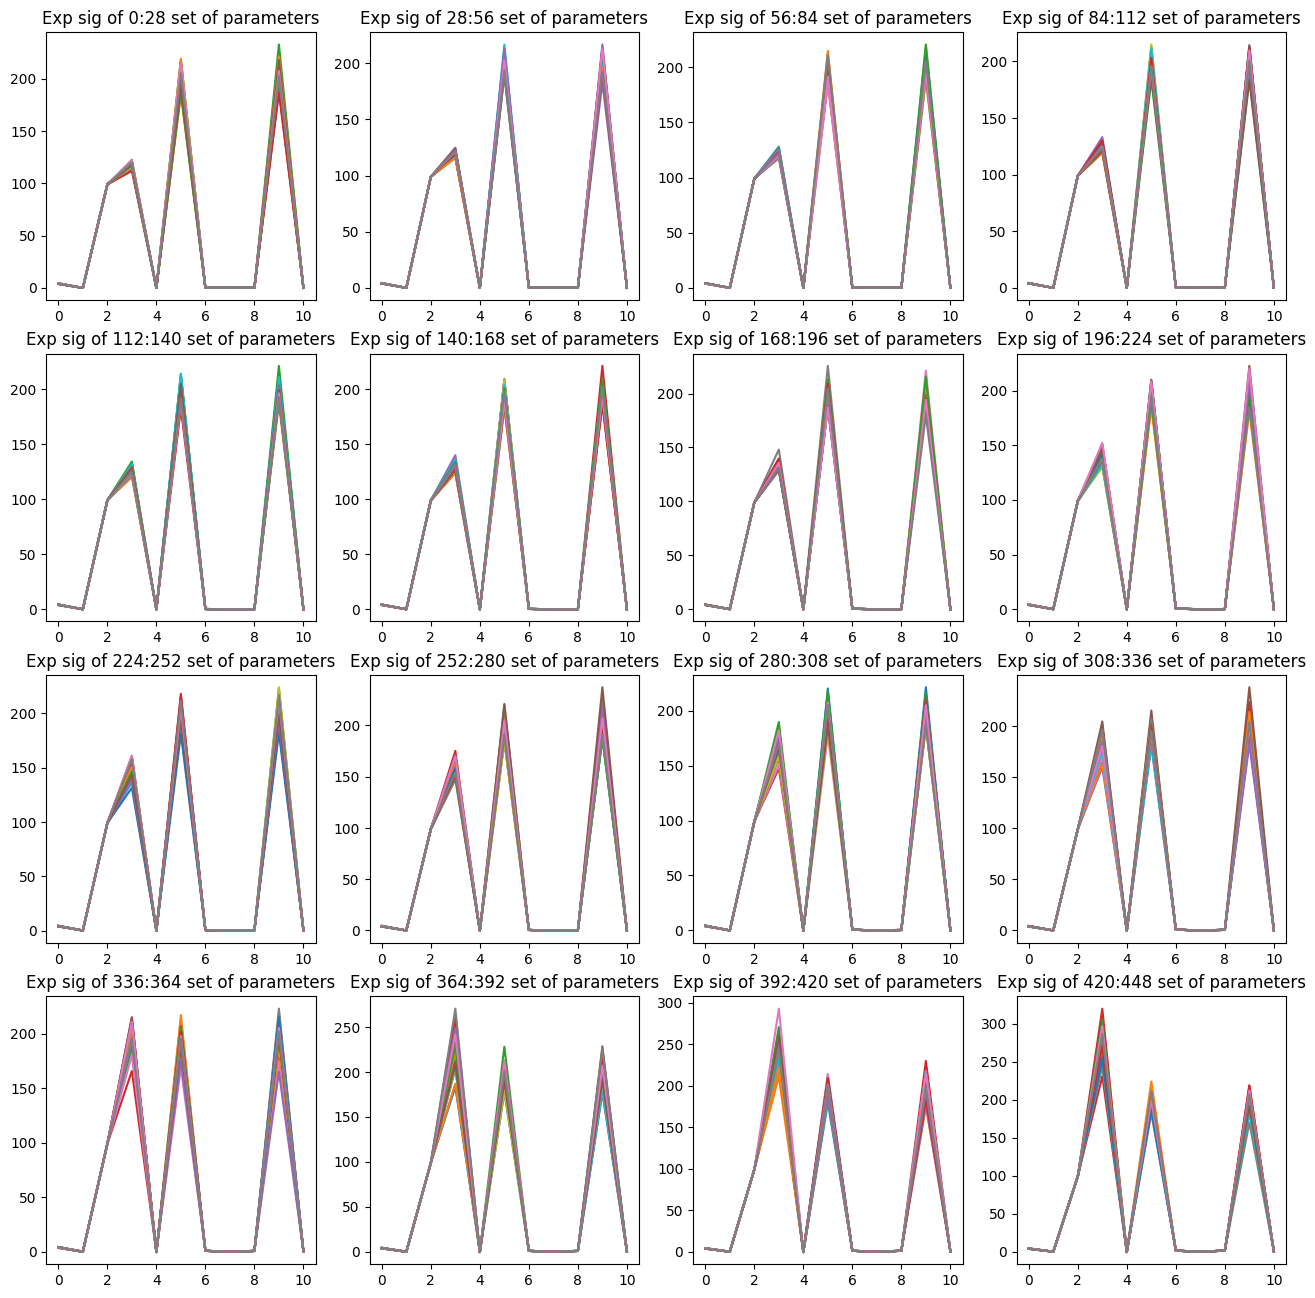

In [27]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text("Exp sig of "  + str(i*28)+":"+ str((i+1)*28)+" set of parameters")
    ax.plot(Exp_signatures_results_sigmas[i*28:(i+1)*28].T[:-1]) #for better illustration exclude last component, since its value is too big